[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/main/examples/segformer_inference_pretrained.ipynb)

In [ ]:
# fix for HF hub download
# see PR https://github.com/albumentations-team/albumentations/pull/2171
!pip install -U git+https://github.com/qubvel/albumentations@patch-2

In [1]:
import requests
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

import torch
import segmentation_models_pytorch as smp

from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# More checkpoints can be found here:
# https://huggingface.co/collections/smp-hub/segformer-6749eb4923dea2c355f29a1f
checkpoint = "smp-hub/segformer-b2-1024x1024-city-160k"

# Load pretrained model and preprocessing function
model = smp.from_pretrained(checkpoint).eval().to(device)
preprocessing = A.Compose.from_pretrained(checkpoint)

# Load image
url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Preprocess image
image = np.array(image)
normalized_image = preprocessing(image=image)["image"]
input_tensor = torch.as_tensor(normalized_image)
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)  # HWC -> BCHW
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    output_mask = model(input_tensor)

# Postprocess mask
mask = torch.nn.functional.interpolate(
    output_mask, size=image.shape[:2], mode="bilinear", align_corners=False
)
mask = mask[0].argmax(0).cpu().numpy()

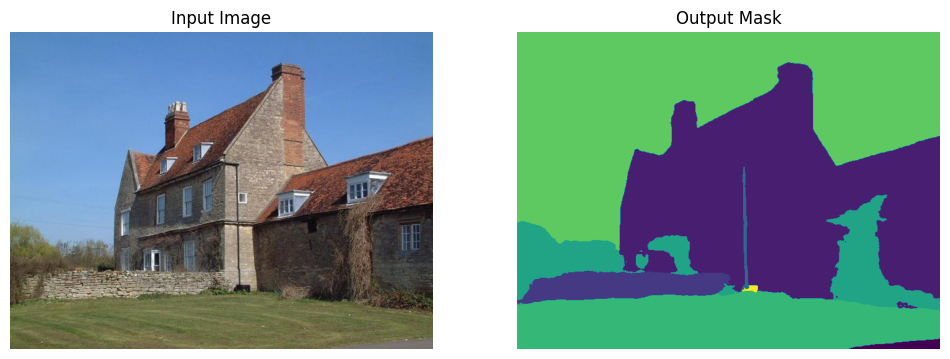

In [3]:
# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.axis("off")
plt.imshow(image)
plt.title("Input Image")

plt.subplot(122)
plt.axis("off")
plt.imshow(mask)
plt.title("Output Mask")

plt.show()